In [2]:
import tensorflow as tf
from tensorflow import keras
# ヘルパーライブラリのインポート
import numpy as np
import matplotlib.pyplot as pl
%matplotlib inline

print(tf.__version__)
print(tf.keras.__version__)

2.0.0
2.2.4-tf


In [3]:
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model, model_from_json
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from tensorflow.keras.datasets import cifar10 #データセットのインポート



In [4]:
def change3class(exp_val, obj_val):
  new_obj = []
  new_exp = []
  # cifar-10のラベル[3]が猫の画像、[5]が犬、[1]が自動車の画像となっていお
  for (x, y) in zip(exp_val, obj_val):
    if (y == 3):
      new_exp.append(x)
      # 猫に[0]のラベル
      new_obj.append(0)
    elif (y == 5):
      new_exp.append(x)
      # 犬に[1]のラベル
      new_obj.append(1)
    elif (y == 1):
      new_exp.append(x)
      # 自動車に[2]のラベルをつける
      new_obj.append(2)
    else:
      pass

  new_exp = np.array(new_exp)
  print("猫、犬、乗り物のデータを取りました")
  return new_exp, new_obj


In [5]:
def build_model(input_shape, cls_num):
  model = Sequential()
  # 使用するカーネル（フィルタ）の数：１６
  # 畳み込みカーネルの行数と列数
  model.add(Conv2D(16, (3,3), padding="same", input_shape=input_shape))
  model.add(Activation("relu")) #　活性化関数ReLUの使用
  model.add(Conv2D(16,(3,3), padding="same"))
  #プーリングの実行
  model.add(MaxPooling2D())
  # 過学習の予防
  model.add(Dropout(0.5))

  model.add(Conv2D(32, (3,3), padding="same"))
  model.add(Activation("relu"))
  model.add(Conv2D(32, (3,3), padding="same"))
  model.add(MaxPooling2D())
  model.add(Dropout(0.5))

  model.add(Conv2D(64, (3, 3), padding="same"))
  model.add(Activation("relu"))
  model.add(Conv2D(64, (3,3), padding="same"))
  model.add(MaxPooling2D())
  model.add(Dropout(0.5))

  model.add(Conv2D(128, (3,3), padding="same"))
  model.add(Activation("relu"))
  model.add(Dropout(0.5))

  model.add(Flatten())
  # denseは通常の全結合ニューラルネットワーク
  model.add(Dense(100, activation = "relu"))
  model.add(Dropout(0.5))

  # 最後のDenseは出力層である。犬、猫、乗り物の３クラスのためのノード数を３にしている
  model.add(Dense(cls_num))
  # 出力層では確率を算出するために、ソフトマックス関数を用いる
  model.add(Activation("softmax"))

  model.compile(
    loss = "categorical_crossentropy", #交差エントロピー
    metrics = ["accuracy"],
    optimizer = "adam" # 最適化アルゴリズムAdam
  )
  return model



In [6]:
# Cifar10データセットcon
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print(type((X_train, y_train)))
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

<class 'tuple'>
(50000, 32, 32, 3) (50000, 1)
(10000, 32, 32, 3) (10000, 1)


In [7]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

X_train, y_train = change3class(X_train, y_train)
X_test, y_test = change3class(X_test, y_test)

y_train = to_categorical(y_train)
y_test  = to_categorical(y_test)

X_train = X_train.astype('float32')
X_test  = X_test.astype('float32')
X_train /= 255.0
X_test /= 255.0

print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

input_shape = (32, 32, 3)
cls_num = 3
model = build_model(input_shape, cls_num)
hist = model.fit(
    X_train, y_train,
    epochs=45,
    batch_size=128,
    validation_data=(X_test, y_test)
)


json_string = model.to_json()
# モデルをJsonフィイルに保存
open('./arch/test.json', 'w').write(json_string)
# 重みパラメータの保存
model.save_weights('./arch/test.hdf5')

# evaluate
score = model.evaluate(X_test, y_test)
print("test loss", score[0])
print("test acc",  score[1])


(50000, 32, 32, 3) (50000, 1)
(10000, 32, 32, 3) (10000, 1)
猫、犬、乗り物のデータを取りました
猫、犬、乗り物のデータを取りました
X_train (15000, 32, 32, 3)
y_train (15000, 3)
X_test (3000, 32, 32, 3)
y_test (3000, 3)


2022-06-15 16:53:20.511821: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-15 16:53:20.514593: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 4. Tune using inter_op_parallelism_threads for best performance.


Train on 15000 samples, validate on 3000 samples
Epoch 1/45
15000/15000 [==============================] - 23s 2ms/sample - loss: 0.8529 - accuracy: 0.5369 - val_loss: 0.6828 - val_accuracy: 0.6280
Epoch 2/45
15000/15000 [==============================] - 26s 2ms/sample - loss: 0.6393 - accuracy: 0.6420 - val_loss: 0.5815 - val_accuracy: 0.6773
Epoch 3/45
15000/15000 [==============================] - 23s 2ms/sample - loss: 0.5951 - accuracy: 0.6707 - val_loss: 0.5551 - val_accuracy: 0.7117
Epoch 4/45
15000/15000 [==============================] - 29s 2ms/sample - loss: 0.5657 - accuracy: 0.6987 - val_loss: 0.5194 - val_accuracy: 0.7233
Epoch 5/45
15000/15000 [==============================] - 22s 1ms/sample - loss: 0.5537 - accuracy: 0.7121 - val_loss: 0.5182 - val_accuracy: 0.7407
Epoch 6/45
15000/15000 [==============================] - 28s 2ms/sample - loss: 0.5230 - accuracy: 0.7331 - val_loss: 0.4811 - val_accuracy: 0.7543
Epoch 7/45
15000/15000 [==============================] -

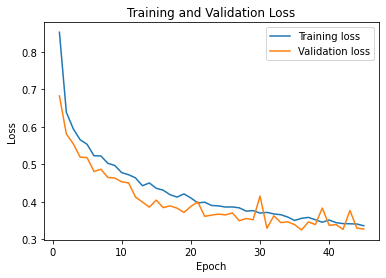

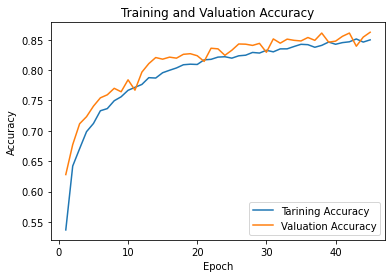

In [8]:

# 学習のグラフか
epochs = range(1, len(hist.history['accuracy']) + 1)

# 損失値グラフ
pl.plot(epochs, hist.history['loss'], label='Training loss', ls='-') #損失値
pl.plot(epochs, hist.history['val_loss'], label='Validation loss')
pl.title("Training and Validation Loss")
pl.xlabel('Epoch')
pl.ylabel('Loss')
pl.legend()
pl.show()
# 正解率
pl.plot(epochs, hist.history['accuracy'], label='Tarining Accuracy')
pl.plot(epochs, hist.history['val_accuracy'], label='Valuation Accuracy')
pl.title("Training and Valuation Accuracy")
pl.xlabel('Epoch')
pl.ylabel('Accuracy')
pl.legend()
pl.show()